with God's blessing 
and https://www.quantopian.com/posts/the-efficient-frontier-markowitz-portfolio-optimization-in-python

In [172]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import finance_scripts as fs
from cvxopt import blas, solvers  
import cvxopt as opt  

solvers.options['show_progress'] = False 

In [5]:
# fs.init()

In [6]:
dClosed = pd.read_pickle("close_cleared.pickle") #  цены закрытия
dVolume = pd.read_pickle("volume_cleared.pickle") #  объёмы продаж
print(dClosed.shape[1]) # Число исследуемых компаний

73


In [10]:
logR = np.log(dClosed / dClosed.shift(1))
e = datetime.strptime('2017-01-02', '%Y-%m-%d')
logR = logR.drop(e)

In [21]:
portfolio_num = 10
portfolio_stocks = logR.columns[:portfolio_num]
portfolio_R=logR[portfolio_stocks]

### Article usage begins ...

Определим функцию для генерации долей $(x_1, ..., x_n)$ активов в портфеле:

In [18]:
def rand_weights(n):  
        ''' Produces n random weights that sum to 1 '''  
        k = np.random.rand(n)  
        return k / sum(k)

In [26]:
print(rand_weights(portfolio_num))

[0.05163619 0.14581677 0.17749061 0.20808118 0.13784667 0.11091801
 0.0583158  0.03506548 0.07418421 0.00064508]


<br>Функция для генерации случайного портфеля, возвращает среднее значени доходности  и стандартное отклонение доходности $\sigma$ портфеля.

Среднее значение расчитывается как взвешенное средних активов, входящий в портфель: 
$\mu=p^\intercal x$, где 
- $x = (x_1, ..., x_n)$ - вектор весов, полученный с помощью функции rand_weights()
- $p$ - вектор средних доходностей активов в портфеле

Стандартное отклонение расчитывается как $\sigma=\sqrt{x^\intercal Cx}$, где
- $C$ - ковариационная матрица доходностей

In [142]:
def random_portfolio(portfolio_R):  
    '''  
    Returns the mean and standard deviation of returns for a random portfolio  
    '''

    p = np.asmatrix(np.mean(portfolio_R, axis=0))  
    w = np.asmatrix(rand_weights(portfolio_R.shape[1]))  
    C = np.asmatrix(np.cov(portfolio_R.values.T))  
    mu = w * p.T  
    sigma = np.sqrt(w * C * w.T)  
    # This recursion reduces outliers to keep plots pretty  
#     if sigma > 2:  
#         return random_portfolio(returns)  
    return mu, sigma  

In [143]:
mu, sigma = random_portfolio(portfolio_R)
print(f'mu = {mu}, sigma = {sigma}')

mu = [[0.00046467]], sigma = [[0.0066562]]


In [97]:
### Зачем там нам матрица ковариаций вообще? 


In [153]:
n_portfolios = 10000
means, stds = np.column_stack([  
    random_portfolio(portfolio_R) for _ in range(n_portfolios)
])

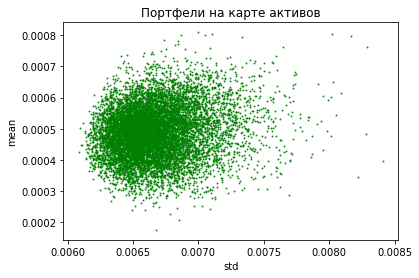

In [160]:
plt.plot(stds, means, 'o', markersize=1, alpha=0.8, color='g')  
plt.xlabel('std')  
plt.ylabel('mean')  
plt.title('Портфели на карте активов')  
plt.show()

In [175]:
## чё тут такое происходит

In [170]:
def optimal_portfolio(portfolio_R):  
    n = portfolio_R.shape[1]
    returns = portfolio_R.values.T
    N = 100  
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]  
    # Convert to cvxopt matrices  
    S = opt.matrix(np.cov(returns))  
    pbar = opt.matrix(np.mean(returns, axis=1))  
    # Create constraint matrices  
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix  
    h = opt.matrix(0.0, (n ,1))  
    A = opt.matrix(1.0, (1, n))  
    b = opt.matrix(1.0)  
    # Calculate efficient frontier weights using quadratic programming  
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']  
                  for mu in mus]  
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  
    returns = [blas.dot(pbar, x) for x in portfolios]  
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]  
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE  
    m1 = np.polyfit(returns, risks, 2)  
    x1 = np.sqrt(m1[2] / m1[0])  
    # CALCULATE THE OPTIMAL PORTFOLIO  
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']  
    return np.asarray(wt), returns, risks

In [174]:

weights, returns, risks = optimal_portfolio(portfolio_R)

plt.plot(stds, means, 'o')  
plt.ylabel('mean')  
plt.xlabel('std')  
plt.plot(risks, returns, 'y-o')  